<a href="https://colab.research.google.com/github/maxodsbjerg/strik-og-kod/blob/main/notebooks/SK_handson_notesbook_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/maxodsbjerg/strik-og-kod.git/main?labpath=notebooks%2FSK_handson_notesbook_eng.ipynb) 

# Knit & Code
author: "Mathias Johansson & Max Odsbjerg Pedersen"

date: "2025-04-06"

Detta dokument består av den kod-delen av workshoppen "Knit and Code" vid Humanistiska och Teologiska Fakulteterna vid Lunds universitet utvecklad I samarbete med _AU Bibliotek vid Det Kongelige Bibliotek_. Workshopen handlar om att dra paralleller mellan stickning och kodning. "Kodning" förstås här som kopplingen mellan kodningsbaserad datahantering och ligger därför inom området datorvetenskap. Eftersom workshopen är gjord i sammanhang av humaniora avser exemplet _textmining_. När man använder _textmining_ är det primära intresset att extrahera information ur stora korpus - vilket är exakt det intresse som många humanister har.

# <Todo>
No recipe is complete without a picture of the final product as one of the first items. And this is no exception. The final result at the end of this document is the visualisation shown just under this paragraph. It shows the most frequently appearing words in old newspaper articles concerning knitting after all stopwords has been removed (it, that, to, and, in - words which bear no larger meaning).

![](https://raw.githubusercontent.com/maxodsbjerg/strik-og-kod/refs/heads/main/notebooks/graphics/strikke_wordcloud.png)

Knitting words and words which accompany them.

<br>


# </Todo>



## Ladda ner och installera Python paket
Vi arbetar i programmeringsspråket [Python ](https://www.python.org/), ett
gratis och _open-source_ programmeringsspråk. Python får mest av sin
funktionalitet genom att importera 'bibliotek', och python har ett mycket brett
ekosystem med bibliotek som erbjuder nästan all funktionalitet du kan tänka
dig. Bland annat många möjligheter för att bearbeta text, statistik och grafisk
presentation av resultaten. Python får mest av sin funktionalitet genom att
importera 'bibliotek', och python har ett mycket starkt ekosystem med bibliotek
som erbjuder nästan alla funktioner du kan tänka dig. Bland annat många
möjligheter för att bearbeta text, statistik och grafisk presentation av
resultaten.

I denna workshop är de relevanta paketen:
- Pandas: Ett kraftfullt bibliotek för datahantering.
- Wordcloud: Ett Python-bibliotek för att generera ordmoln från text.
- Matplotlib: Ett bibliotek för att skapa statiska, animerade och interaktiva
  visualiseringar i Python.

Vi kommer att installera dessa paket med hjälp av pip, Pythons pakethanterare.
Pip är ett kommandoradsverktyg som gör det lätt att installera och hantera
Python-paket.

Vi använder också två bibliotek från _standardbiblioteket_:
- re: Ett reguljärt uttrycksmodul -- för textmönstermatchning.
- Counter: Ett objekt för att räkna förekomster av objekt.


In [25]:
print("install and load libraries")
!python -m pip install pandas wordcloud matplotlib

import re
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

install and load libraries

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## Data – utterances about ABM

The first thing we need is some text. 
We will here use _utterances_ from Swedish Parliamentary debates from 1867-2022.
In order to find and access these _utterances_ we will use the[Riksdagsdebatter.se](https://riksdagsdebatter.se/public/index.html#/about) which offers a graphical interface for searching and accessing the debates.
In order to find all the utterances mentioning ABM we search for the following three keywords:
- `arkiv*`
- `bibliotek*`
- `muse*`
Where `*` is a trunctation mark -- expanding to find *all words* starting with `arkiv`, `bibliotek`, or `muse` (1477 words according to the GUI).

`Riksdagsdebatter.se` does not prove an API and the ~9k results are paginated at 50 results per page.
However, the source material is available at: [the-swedish-parliament-corpus](https://github.com/swerik-project/the-swedish-parliament-corpus)
where one can download the entire corpus and all speaker-metadata.
In preparation for this workshop I have downloaded the records, filtered out all the utterances that do NOT mention at least one of our keywords and restructured the result into a CSV file. [scrip](https://gist.github.com/mathjoha/edcdaf57c5c2d58d9f6b58a6350b811d) [corpus](https://raw.githubusercontent.com/mathjoha/strik-og-kod/refs/heads/main/the-swedish-parliament-corpus_ABM_.csv)


### Load data

In order to access the data for the workshow it needs to be downloaded, which can easily be done with the `wget` program as such:

In [26]:
!wget -c -nc "https://raw.githubusercontent.com/mathjoha/strik-og-kod/refs/heads/main/the-swedish-parliament-corpus_ABM_.csv" -O corpus.csv

File ‘corpus.csv’ already there; not retrieving.


Then we use the function `read_csv` from the pandas library to load the file's contents into a DataFrame and keep that in memory under the variable name "strik".
A DataFrame is comparable to spreadsheet in that it is a large matrix that stores data we work with.


In [27]:
riksdag = pd.read_csv("corpus.csv")

This gives us a new Pandas DataFrame named ”riksdag" and containing 13755 rows and 5 columns.

What is especially interesting for us is the column “content” – This is
where the transcribed utterenaces are stored. Some of this text will not be easy
on the eyes as they are filled with errors, and it is here where you meet the
first downside of working with old text: OCR-errors.

To understand why these errors occur it is necessary to turn towards the
digitalization. In this process the newspapers are photocopied (either from
microfilm or from the original), afterwards a computer algorithm runs through
the pages of the newspapers. The computer algorithm does two things:

  1. Segmenting the articles – with other words the algorithm guesses which
  body belongs to which headline.
  2. Doing text recognition so that the text becomes digital and becomes
  searchable. This is also called OCR (Optical Character Recognition).

This algorithm has been developed with modern newspapers in mind and is
therefore pretty precise when used on more recent newspapers (from 1910
until today). If the algorithm is used on older material the quality of
the digitalization dwindles. This is in part due to layout of older newspapers
differ from modern layouts. One of the big problems are that the text
recognition is bad. This is a result of the typeface used in old newspapers
which used fraktur when pressing newspapers. Some will recognize the typeface
as gothic letters or curly letters. ![](https://raw.githubusercontent.com/maxodsbjerg/strik-og-kod/refs/heads/main/pics/fraktur.png) Our hope here is
that the data is so large that we can gather something interesting despite
the OCR-errors.



## The Text mining task


First we will convert the text into lowercase and split it into words using [Regular expression](https://en.wikipedia.org/wiki/Regex).
We store these `lists` of lowercase words in the DataFrame in the column `word` and we expand this column into a new dataframe where each word has its own row.


In [28]:
riksdag['word'] = riksdag.content.apply(lambda x: re.findall(r'\w+', x.lower()))
riksdag_tidy = riksdag.explode('word')

Let us just print out the new data frame to see how the tidytext format looks in practice. This is achieved by writing the name of the data frame:

In [29]:
riksdag_tidy

,id,date,speaker,content,xml,word
0,i-8qLa4zsKhR1MCZqMWuA4Dm,1899-02-10,i-5u7PKe6iMvu5KFkCh55sUt,"i de förslag, som här framkommit, angående inr...",1899/prot-1899--ak--006.xml,i
0,i-8qLa4zsKhR1MCZqMWuA4Dm,1899-02-10,i-5u7PKe6iMvu5KFkCh55sUt,"i de förslag, som här framkommit, angående inr...",1899/prot-1899--ak--006.xml,de
0,i-8qLa4zsKhR1MCZqMWuA4Dm,1899-02-10,i-5u7PKe6iMvu5KFkCh55sUt,"i de förslag, som här framkommit, angående inr...",1899/prot-1899--ak--006.xml,förslag
0,i-8qLa4zsKhR1MCZqMWuA4Dm,1899-02-10,i-5u7PKe6iMvu5KFkCh55sUt,"i de förslag, som här framkommit, angående inr...",1899/prot-1899--ak--006.xml,som
0,i-8qLa4zsKhR1MCZqMWuA4Dm,1899-02-10,i-5u7PKe6iMvu5KFkCh55sUt,"i de förslag, som här framkommit, angående inr...",1899/prot-1899--ak--006.xml,här
...,...,...,...,...,...,...
13754,i-78643e31204d2f70-3,1984-06-07,i-N7WL5aLLwEPfYa71gsUxQx,Herr talman! Det rörde inte museerna utan kult...,198384/prot-198384--166.xml,att
13754,i-78643e31204d2f70-3,1984-06-07,i-N7WL5aLLwEPfYa71gsUxQx,Herr talman! Det rörde inte museerna utan kult...,198384/prot-198384--166.xml,ha
13754,i-78643e31204d2f70-3,1984-06-07,i-N7WL5aLLwEPfYa71gsUxQx,Herr talman! Det rörde inte museerna utan kult...,198384/prot-198384--166.xml,någon
13754,i-78643e31204d2f70-3,1984-06-07,i-N7WL5aLLwEPfYa71gsUxQx,Herr talman! Det rörde inte museerna utan kult...,198384/prot-198384--166.xml,vetenskaplig


If we flip through the columns (with the little black arrow in the top-right corner) the last column will now be “word” which only contains single words.

## Analysis

### Wordcloud

To get an overview of our dataset we will begin by counting the most used words in the article about knitting in the period 1845 to 1850:


In [30]:
Counter(riksdag_tidy.word.values).most_common()

[('att', 45726),
 ('det', 32234),
 ('i', 30390),
 ('och', 29682),
 ('som', 25179),
 ('för', 20199),
 ('är', 18396),
 ('en', 17193),
 ('till', 15352),
 ('på', 14798),
 ('har', 14743),
 ('jag', 14395),
 ('av', 14084),
 ('den', 13930),
 ('om', 12639),
 ('de', 12260),
 ('ett', 10429),
 ('med', 10362),
 ('man', 9748),
 ('inte', 8257),
 ('vi', 7722),
 ('kan', 6164),
 ('så', 6102),
 ('detta', 5987),
 ('icke', 5700),
 ('men', 5383),
 ('skulle', 5304),
 ('af', 4359),
 ('sig', 4333),
 ('från', 4035),
 ('nu', 3990),
 ('också', 3793),
 ('skall', 3594),
 ('vara', 3589),
 ('här', 3560),
 ('denna', 3455),
 ('då', 3396),
 ('museer', 3270),
 ('museet', 3241),
 ('eller', 3214),
 ('dessa', 3057),
 ('när', 2973),
 ('under', 2922),
 ('vill', 2921),
 ('få', 2917),
 ('kunna', 2867),
 ('andra', 2756),
 ('vid', 2742),
 ('herr', 2700),
 ('museum', 2695),
 ('mycket', 2669),
 ('finns', 2618),
 ('var', 2550),
 ('ha', 2495),
 ('år', 2457),
 ('där', 2418),
 ('än', 2414),
 ('utan', 2356),
 ('kommer', 2318),
 ('vad', 

<br> To no one’s surprise most frequent words in the dataset is the grammatical particles. One way to negate these words is by using a stopword list which can be used to remove unwanted words. For this we will use a stopwords-list published publicly by [@peterdalle](https://gist.github.com/peterdalle):

In [31]:
!wget "https://gist.githubusercontent.com/peterdalle/8865eb918a824a475b7ac5561f2f88e9/raw/cc1d05616e489576c1b934289711f041ff9b2281/swedish-stopwords.txt" -O stopord.txt

--2025-04-06 14:31:10--  https://gist.githubusercontent.com/peterdalle/8865eb918a824a475b7ac5561f2f88e9/raw/cc1d05616e489576c1b934289711f041ff9b2281/swedish-stopwords.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2702 (2.6K) [text/plain]
Saving to: ‘stopord.txt’

stopord.txt         100%[===================>]   2.64K  --.-KB/s    in 0s      

2025-04-06 14:31:10 (51.5 MB/s) - ‘stopord.txt’ saved [2702/2702]



In [32]:
with open('stopord.txt', 'r', encoding='utf-8') as f:
  stopord = f.read().split('\n')
stopord += ['icke']

<br>


We will filter out all the stopwords !!

In [33]:
def not_stopword(word):
  return word not in stopord

words = Counter(filter(not_stopword, riksdag_tidy.word.values)).most_common()
words

[('af', 4359),
 ('museer', 3270),
 ('museet', 3241),
 ('herr', 2700),
 ('museum', 2695),
 ('år', 2457),
 ('museerna', 2094),
 ('talman', 2053),
 ('arkiv', 2018),
 ('fråga', 1903),
 ('kronor', 1694),
 ('ju', 1682),
 ('utskottet', 1611),
 ('förslag', 1528),
 ('frågan', 1513),
 ('t', 1513),
 ('000', 1484),
 ('maj', 1428),
 ('regeringen', 1415),
 ('riksdagen', 1285),
 ('bör', 1273),
 ('statliga', 1228),
 ('nordiska', 1178),
 ('såsom', 1094),
 ('se', 1045),
 ('verksamhet', 1045),
 ('äro', 1035),
 ('tycker', 987),
 ('fri', 979),
 ('tid', 964),
 ('entré', 951),
 ('anslag', 944),
 ('kungl', 943),
 ('1', 940),
 ('sådan', 910),
 ('statens', 908),
 ('stockholm', 890),
 ('arbete', 888),
 ('svenska', 877),
 ('sådana', 876),
 ('anser', 874),
 ('landet', 866),
 ('ej', 863),
 ('historiska', 851),
 ('museets', 844),
 ('åt', 815),
 ('sverige', 811),
 ('staten', 808),
 ('fru', 802),
 ('endast', 800),
 ('just', 795),
 ('samlingar', 795),
 ('sådant', 764),
 ('skäl', 759),
 ('vissa', 758),
 ('emellertid', 7

<br> We can already see quite a few interesting words. Something points
towards a connection between maids that are seeking “condition” which back
in the day meant a “service position” or a space of sorts. We can also see
an OCR-error “eondition” and another spelling of condition, “kondition”.

But a list is a little boring to look at. Could we perhaps create a
beautiful wordcloud? Of course we can!


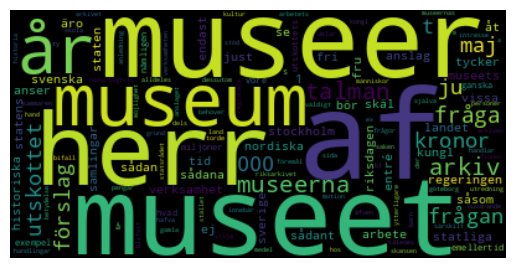

In [34]:
wc = WordCloud()
wc.generate_from_frequencies(
  Counter(filter(not_stopword, riksdag_tidy.word.values))).to_file('wc.png')
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()